In [1]:
import qiskit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram,plot_distribution
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit_aer import Aer, AerSimulator
import matplotlib
import pylatexenc

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def create_qgb_circuit(levels):
    assert levels >= 1, "Levels must be >= 1"

    total_qubits = 2 * levels + 2
    middle = levels + 1

    qreg = QuantumRegister(total_qubits, name="q")
    creg = ClassicalRegister(levels + 1, name="c")
    qc = QuantumCircuit(qreg, creg)

    # Initial superposition and ball placement
    qc.h(0)
    qc.x(middle)

    ball_positions = [middle]

    for step in range(levels):
        qc.reset(0)
        qc.h(0)

        new_positions = set()
        positions_this_step = sorted(ball_positions)

        for i, pos in enumerate(positions_this_step):
            left = pos - 1
            right = pos + 1

            if left >= 1 and right < total_qubits:
                qc.cswap(0, left, pos)
                qc.cx(pos, 0)
                qc.cswap(0, pos, right)

                # Only apply extra CX if this is NOT the last position of this step
                if step >= 1 and i < len(positions_this_step) - 1:
                    qc.cx(right, 0)

                new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measure only the odd-indexed qubits (like [1, 3, 5, 7, 9] for level 4)
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        qc.measure(q, creg[i])

    return qc

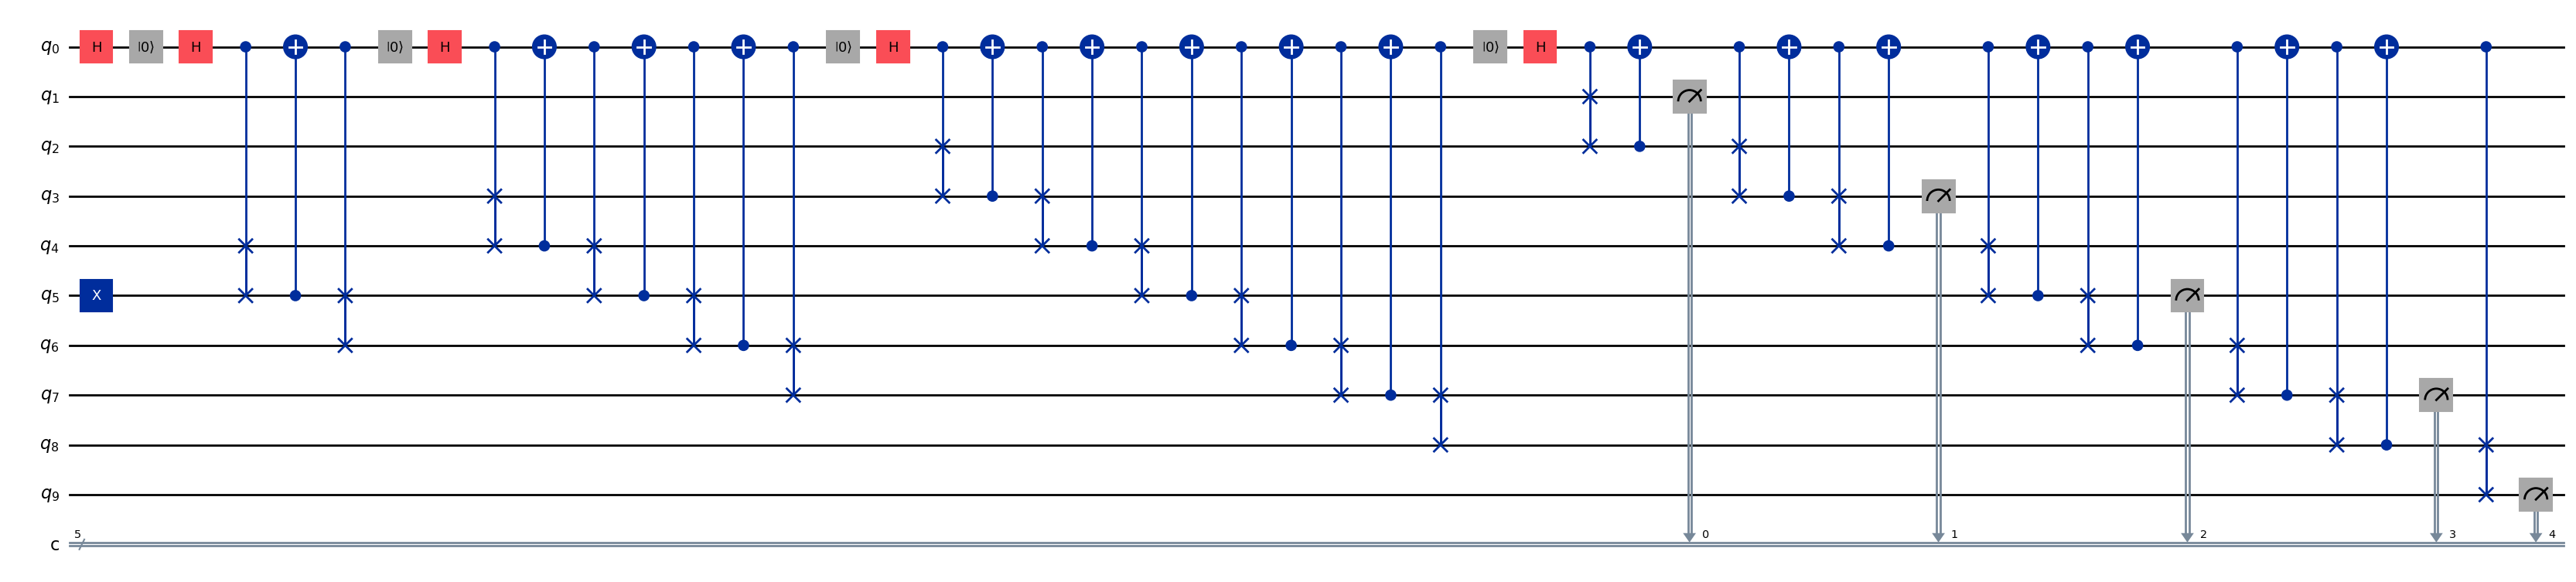

In [3]:
qc = create_qgb_circuit(4)
qc.draw('mpl', fold = -1)

Raw Counts: {'00010': 5004, '00100': 7564, '01000': 4912, '00001': 1251, '10000': 1269}


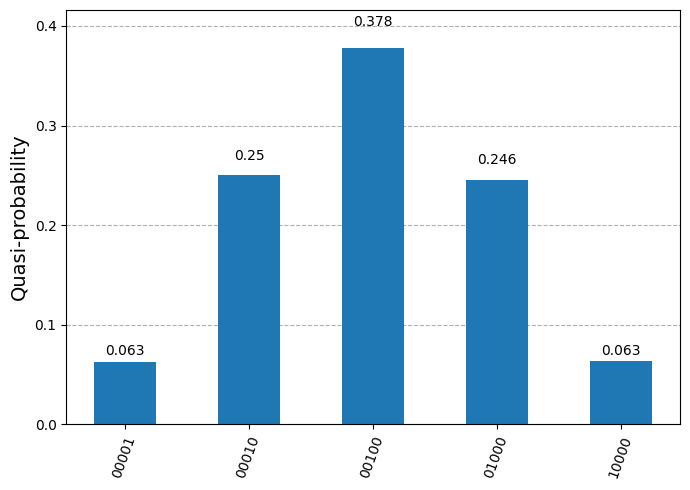

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assume qc is your QGB circuit (e.g., level=4)
# Step 1: Simulate using Sampler and AerSimulator
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pass_manager.run(qc)

sampler = Sampler(mode=backend)
job_result = sampler.run([qc_transpiled], shots=20000).result()

# Extract measurement counts from result
counts = job_result[0].data.c.get_counts()
# Note: The exact access pattern may vary with Qiskit version;
# sometimes it's .data.c or .data.meas — adjust accordingly based on your transpiled circuit.

print("Raw Counts:", counts)
plot_distribution(counts)

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 1.999700
  Std dev  = 0.998374
  Variance = 0.996750

Per-position counts (0..4):
  pos 0: 1233
  pos 1: 5032
  pos 2: 7482
  pos 3: 5014
  pos 4: 1239

Number of full blocks of 8: 2500
Printing every block (index: [values] -> sum):

Block     1: [3, 2, 0, 3, 1, 1, 3, 2]  -> sum = 15
Block     2: [1, 1, 1, 2, 2, 2, 3, 2]  -> sum = 14
Block     3: [2, 3, 3, 0, 1, 3, 2, 2]  -> sum = 16
Block     4: [4, 1, 3, 3, 3, 1, 3, 2]  -> sum = 20
Block     5: [2, 2, 3, 4, 2, 1, 2, 1]  -> sum = 17
Block     6: [3, 3, 3, 3, 2, 2, 2, 1]  -> sum = 19
Block     7: [1, 2, 2, 1, 1, 2, 1, 2]  -> sum = 12
Block     8: [3, 0, 3, 2, 3, 1, 2, 3]  -> sum = 17
Block     9: [2, 2, 2, 3, 2, 3, 3, 2]  -> sum = 19
Block    10: [2, 4, 1, 0, 2, 0, 1, 1]  -> sum = 11
Block    11: [3, 3, 2, 1, 2, 3, 2, 1]  

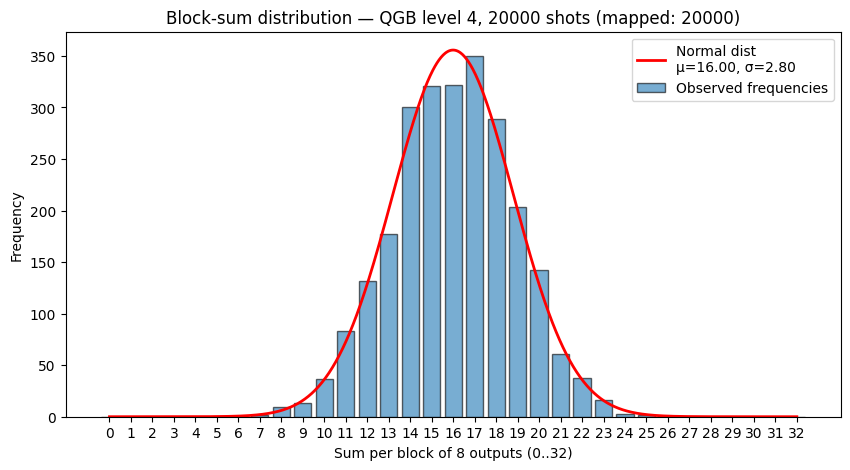

In [5]:
# # ------------------------------
# # Optional: include your create_qgb_circuit here if you don't already have it
# # (If you already have qc built earlier, you can skip this function and set qc directly)
from collections import Counter
# def create_qgb_circuit(levels):
#     total_qubits = 2 * levels + 2
#     middle = levels + 1
#     qc = QuantumCircuit(total_qubits, levels + 1)

#     # initial
#     qc.h(0)
#     qc.x(middle)

#     ball_positions = [middle]
#     for step in range(levels):
#         qc.reset(0)
#         qc.h(0)
#         new_positions = set()
#         positions_this_step = sorted(ball_positions)
#         for i, pos in enumerate(positions_this_step):
#             left = pos - 1
#             right = pos + 1
#             if left >= 1 and right < total_qubits:
#                 qc.cswap(0, left, pos)
#                 qc.cx(pos, 0)
#                 qc.cswap(0, pos, right)
#                 if step >= 1 and i < len(positions_this_step) - 1:
#                     qc.cx(right, 0)
#                 new_positions.update([left, right])
#         ball_positions = sorted(new_positions)

#     # measure odd qubits (1,3,5,...)
#     measure_qubits = [i for i in range(1, total_qubits, 2)]
#     for i, q in enumerate(measure_qubits[:levels + 1]):
#         qc.measure(q, i)
#     return qc

# # Build or load your 4-level circuit:
# qc = create_qgb_circuit(4)
# # ------------------------------

# Simulator + transpile
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(qc)

# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = qc.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
print("Printing every block (index: [values] -> sum):\n")
for i, block in enumerate(blocks, start=1):
    print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---
# --- frequency of sums 0..32 and plot ---
sum_counts = Counter(block_sums)
freqs = [sum_counts.get(s, 0) for s in range(33)]

print("\nBlock-sum frequencies (0..32):")
for s, f in enumerate(freqs):
    print(f" sum {s:2d}: {f}")

# Prepare histogram and normal distribution curve
plt.figure(figsize=(10,5))

# Histogram (bar plot)
plt.bar(range(33), freqs, edgecolor='black', alpha=0.6, label="Observed frequencies")

# Normal distribution curve (scaled to match histogram total counts)
x_vals = np.linspace(0, 32, 1000)
mean_blocks = block_sums.mean()
std_blocks = block_sums.std(ddof=1)

# Normal PDF, scaled by (total blocks × bin width)
pdf_vals = norm.pdf(x_vals, loc=mean_blocks, scale=std_blocks)
pdf_scaled = pdf_vals * len(block_sums) * 1  # bin width = 1

plt.plot(x_vals, pdf_scaled, 'r-', linewidth=2, label=f"Normal dist\nμ={mean_blocks:.2f}, σ={std_blocks:.2f}")

plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum distribution — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
plt.xticks(range(0, 33, 1))
plt.legend()
plt.show()


In [6]:
# sum_counts = Counter(block_sums)
# freqs = [sum_counts.get(s, 0) for s in range(33)]

# print("\nBlock-sum frequencies (0..32):")
# for s, f in enumerate(freqs):
#     print(f" sum {s:2d}: {f}")

# # plot histogram (33 bins: 0..32)
# plt.figure(figsize=(10,5))
# plt.bar(range(33), freqs, edgecolor='black')
# plt.xlabel("Sum per block of 8 outputs (0..32)")
# plt.ylabel("Frequency")
# plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
# plt.xticks(range(0,33,2))
# plt.show()


###  **Baised Quantum Galton Board**

In [18]:
import numpy as np
def create_biased_qgb_circuit(levels, theta= 2 * np.pi/3):
    """
    Create a biased Quantum Galton Board circuit.
    - levels: number of levels (integer >= 1)
    - theta: rotation angle around X-axis on control qubit (float)
             theta=pi/2 ~ balanced (like Hadamard), smaller/larger biases the distribution
    """
    assert levels >= 1, "Levels must be >= 1"
    total_qubits = 2 * levels + 2
    ball = levels + 1

    quantum_circ = QuantumCircuit(total_qubits, levels + 1)

    # Initial biased superposition on control qubit q0
    quantum_circ.rx(theta, 0)
    quantum_circ.x(ball)

    ball_positions = [ball]

    for step in range(levels):
        quantum_circ.reset(0)
        quantum_circ.rx(theta, 0)  # biased rotation instead of Hadamard

        new_positions = set()
        positions_this_step = sorted(ball_positions)

        for i, pos in enumerate(positions_this_step):
            left = pos - 1
            right = pos + 1

            if left >= 1 and right < total_qubits:
                quantum_circ.cswap(0, left, pos)
                quantum_circ.cx(pos, 0)
                quantum_circ.cswap(0, pos, right)

                if step >= 1 and i < len(positions_this_step) - 1:
                    quantum_circ.cx(right, 0)

                new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measure odd qubits as usual
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        quantum_circ.measure(q, i)

    return quantum_circ

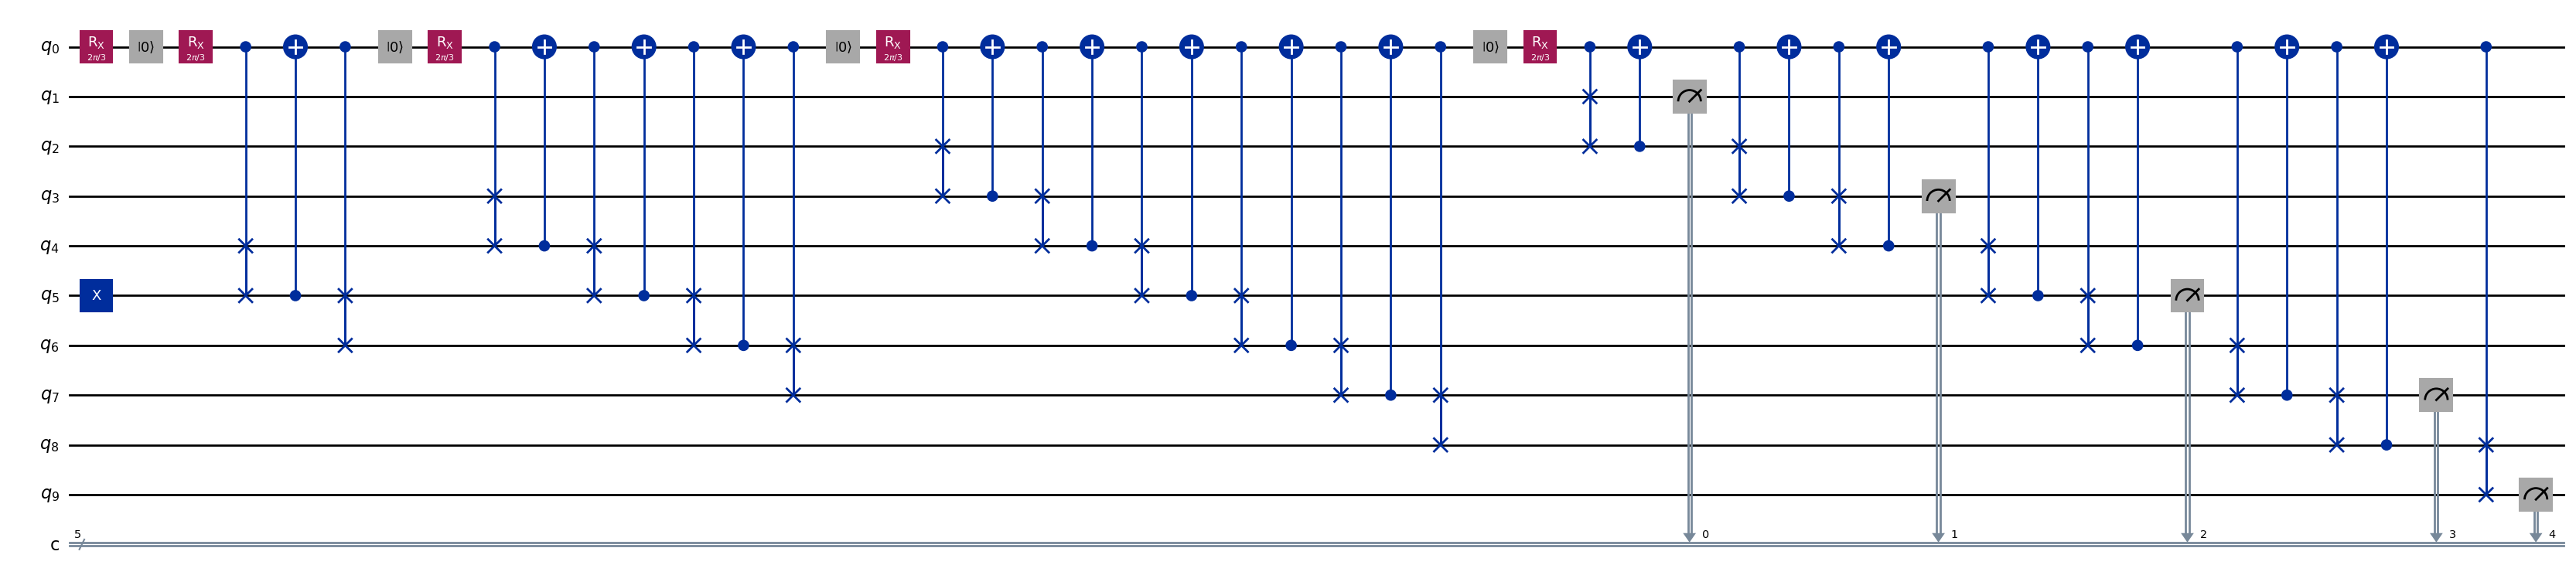

In [19]:
quantum_circ = create_biased_qgb_circuit(4)
quantum_circ.draw('mpl', fold = -1)

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 3.012350
  Std dev  = 0.864196
  Variance = 0.746835

Per-position counts (0..4):
  pos 0: 76
  pos 1: 895
  pos 2: 4205
  pos 3: 8354
  pos 4: 6470

Number of full blocks of 8: 2500
Printing every block (index: [values] -> sum):

Block     1: [3, 3, 3, 4, 4, 1, 4, 2]  -> sum = 24
Block     2: [4, 4, 3, 3, 4, 4, 4, 4]  -> sum = 30
Block     3: [4, 3, 3, 4, 4, 4, 3, 3]  -> sum = 28
Block     4: [2, 3, 4, 3, 2, 4, 4, 2]  -> sum = 24
Block     5: [4, 2, 4, 4, 4, 2, 2, 4]  -> sum = 26
Block     6: [4, 2, 3, 3, 1, 3, 4, 2]  -> sum = 22
Block     7: [4, 4, 2, 4, 2, 3, 3, 3]  -> sum = 25
Block     8: [3, 3, 3, 4, 3, 3, 3, 4]  -> sum = 26
Block     9: [2, 2, 2, 3, 2, 3, 4, 3]  -> sum = 21
Block    10: [3, 4, 3, 3, 3, 4, 2, 2]  -> sum = 24
Block    11: [4, 3, 4, 4, 3, 3, 4, 2]  -> 

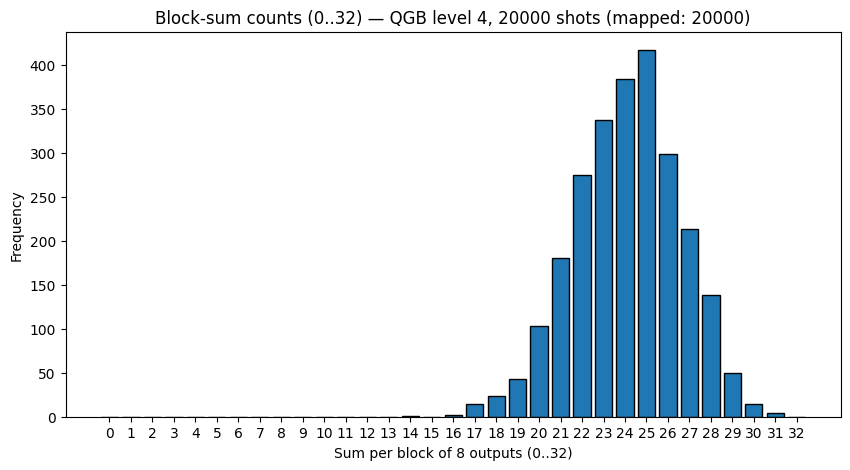

In [20]:
from collections import Counter
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(quantum_circ)


# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = quantum_circ.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
print("Printing every block (index: [values] -> sum):\n")
for i, block in enumerate(blocks, start=1):
    print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---

sum_counts = Counter(block_sums)
freqs = [sum_counts.get(s, 0) for s in range(33)]

print("\nBlock-sum frequencies (0..32):")
for s, f in enumerate(freqs):
    print(f" sum {s:2d}: {f}")

# plot histogram (33 bins: 0..32)
plt.figure(figsize=(10,5))
plt.bar(range(33), freqs, edgecolor='black')
plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
plt.xticks(range(0,33,1))
plt.show()









# sum_counts = Counter(block_sums)
# freqs = [sum_counts.get(s, 0) for s in range(33)]

# print("\nBlock-sum frequencies (0..32):")
# for s, f in enumerate(freqs):
#     print(f" sum {s:2d}: {f}")

# # Prepare histogram and normal distribution curve
# plt.figure(figsize=(10,5))

# # Histogram (bar plot)
# plt.bar(range(33), freqs, edgecolor='black', alpha=0.6, label="Observed frequencies")

# # Normal distribution curve (scaled to match histogram total counts)
# x_vals = np.linspace(0, 32, 1000)
# mean_blocks = block_sums.mean()
# std_blocks = block_sums.std(ddof=1)

# # Normal PDF, scaled by (total blocks × bin width)
# pdf_vals = norm.pdf(x_vals, loc=mean_blocks, scale=std_blocks)
# pdf_scaled = pdf_vals * len(block_sums) * 1  # bin width = 1

# plt.plot(x_vals, pdf_scaled, 'r-', linewidth=2, label=f"Normal dist\nμ={mean_blocks:.2f}, σ={std_blocks:.2f}")

# plt.xlabel("Sum per block of 8 outputs (0..32)")
# plt.ylabel("Frequency")
# plt.title(f"Block-sum distribution — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
# plt.xticks(range(0, 33, 2))
# plt.legend()
# plt.show()


#### **Fine Grained Quantum Galton Board**

In [10]:
def create_fine_grained_biased_qgb(levels, theta=np.pi/2, phi=np.pi/4):
    total_qubits = 2 * levels + 2
    middle = levels + 1

    qreg = QuantumRegister(total_qubits, name="q")
    creg = ClassicalRegister(levels + 1, name="c")
    qc = QuantumCircuit(qreg, creg)

    # Step 0: Rotation instead of Hadamard
    qc.rx(theta, 0)
    qc.x(middle)

    ball_positions = [middle]

    for step in range(levels):
        qc.reset(0)
        qc.rx(theta, 0)

        positions_this_step = sorted(ball_positions)
        new_positions = set()

        for i, pos in enumerate(positions_this_step):
            left, right = pos - 1, pos + 1

            qc.cswap(0, left, pos)
            qc.cx(pos, 0)
            qc.cswap(0, pos, right)

            # Replace extra CX with Rx+reset (only if not last pos and step >= 1)
            if step >= 1 and i < len(positions_this_step) - 1:
                qc.rx(phi, 0)
                qc.reset(0)

            new_positions.update([left, right])

        ball_positions = sorted(new_positions)

    # Measurement
    measure_qubits = [i for i in range(1, total_qubits, 2)]
    for i, q in enumerate(measure_qubits[:levels + 1]):
        qc.measure(q, creg[i])

    return qc

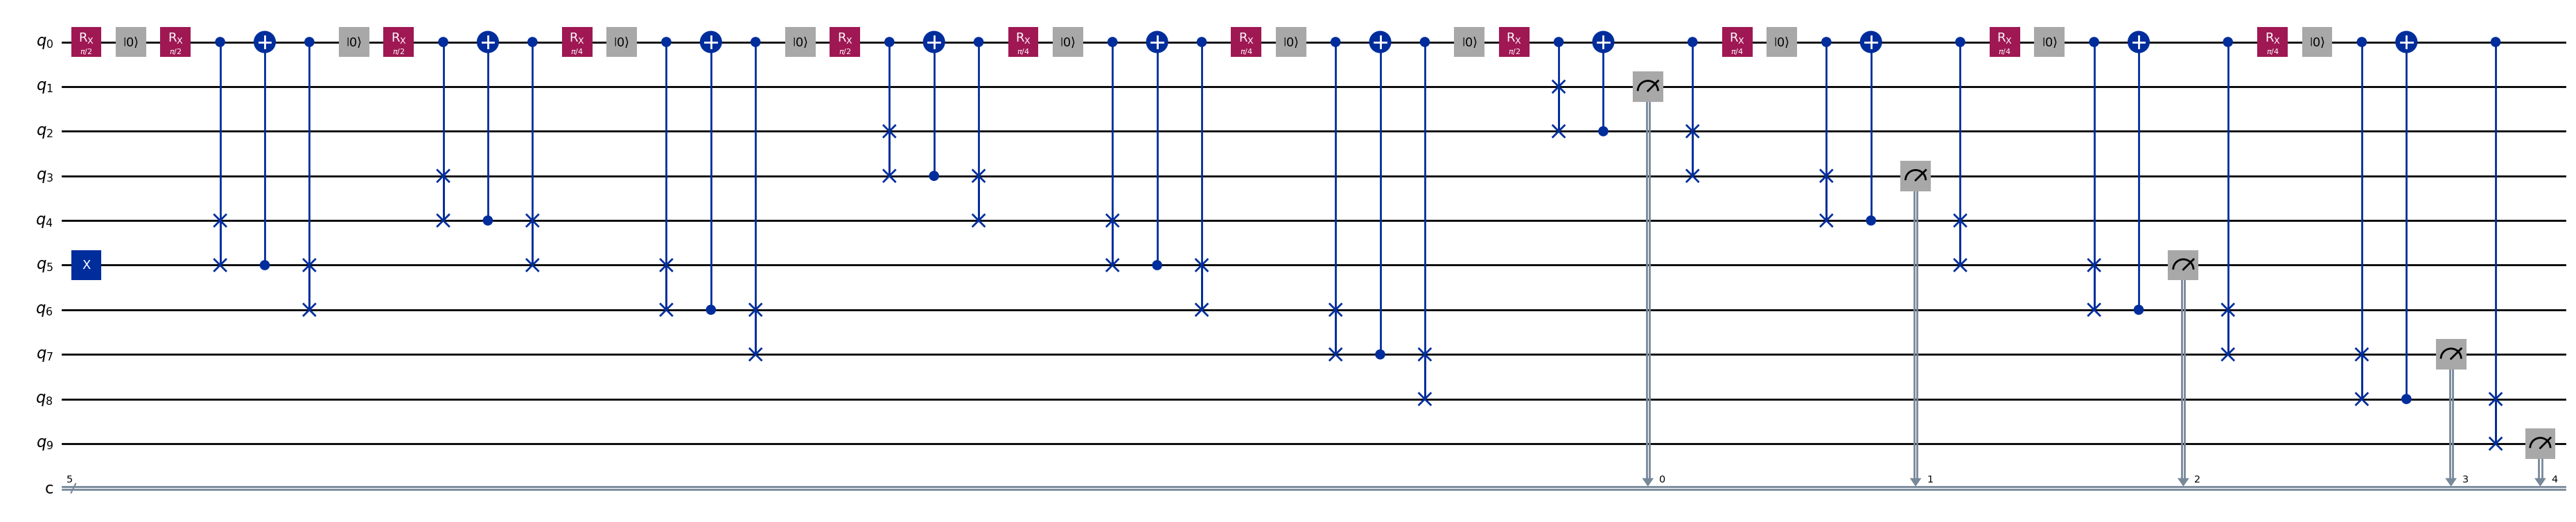

In [11]:
# angle = np.pi
qc  = create_fine_grained_biased_qgb(4)
qc.draw('mpl', fold = -1)

Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.
Total shots: 20000, Mapped shots: 20000, Unknown patterns: 0

Single-shot mapped statistics (values in {0,1,2,3,4}):
  Mean     = 0.943200
  Std dev  = 1.200477
  Variance = 1.441146

Per-position counts (0..4):
  pos 0: 9989
  pos 1: 4930
  pos 2: 2559
  pos 3: 1272
  pos 4: 1250

Number of full blocks of 8: 2500
Printing every block (index: [values] -> sum):

Block     1: [0, 4, 0, 1, 4, 2, 1, 1]  -> sum = 13
Block     2: [0, 0, 0, 1, 0, 2, 0, 2]  -> sum = 5
Block     3: [1, 0, 0, 2, 0, 1, 0, 1]  -> sum = 5
Block     4: [2, 2, 1, 0, 0, 3, 4, 0]  -> sum = 12
Block     5: [0, 0, 1, 4, 0, 1, 0, 4]  -> sum = 10
Block     6: [4, 0, 0, 0, 0, 0, 0, 1]  -> sum = 5
Block     7: [1, 0, 1, 0, 0, 4, 4, 3]  -> sum = 13
Block     8: [2, 1, 3, 0, 4, 0, 1, 0]  -> sum = 11
Block     9: [4, 0, 0, 1, 1, 1, 1, 4]  -> sum = 12
Block    10: [0, 1, 4, 0, 0, 0, 1, 0]  -> sum = 6
Block    11: [1, 0, 2, 1, 0, 3, 1, 0]  -> s

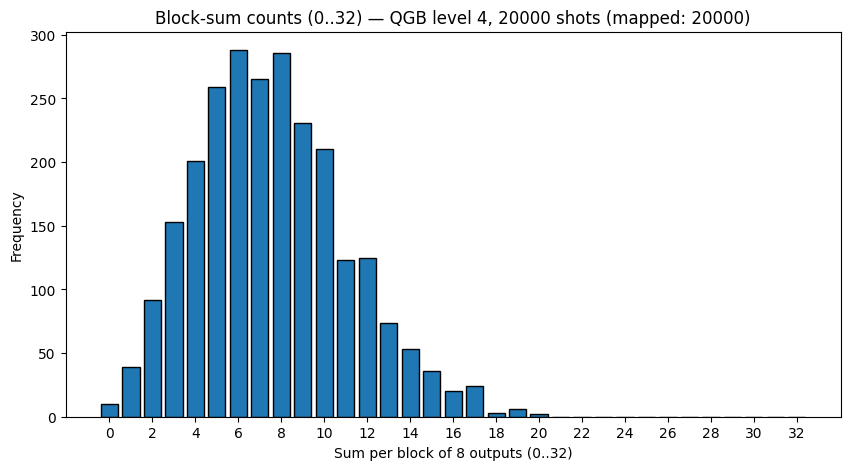

In [12]:
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)  # use 1 for speed; change to 3 if you want heavy optimization
qc_transpiled = pass_manager.run(qc)

# Run with memory=True if possible (so we get per-shot bitstrings)
job = backend.run(qc_transpiled, shots=20000, memory=True)
result = job.result()

# --- robust extraction of per-shot bitstrings (as strings) ---
shot_bitstrings = None

# Try a few common ways to get the shot memory:
try:
    # new Aer result API
    shot_bitstrings = result.get_memory(0)   # usually returns list of bitstrings (strings)
except Exception:
    pass

if shot_bitstrings is None:
    # Sometimes memory is under results[0].data.memory
    try:
        shot_bitstrings = result.results[0].data.memory
    except Exception:
        pass

if shot_bitstrings is None:
    # Fallback: expand counts into a shot list (order will be arbitrary)
    try:
        counts = result.get_counts(0)
    except Exception:
        try:
            counts = result.results[0].data.counts
        except Exception:
            raise RuntimeError("Couldn't extract memory or counts from result. Check Qiskit/Aer version.")
    # expand counts -> list of strings
    shot_bitstrings = []
    for bitstr, c in counts.items():
        shot_bitstrings.extend([bitstr] * c)

# normalize bitstrings length (pad left with zeros if needed)
n_meas = qc.num_clbits  # expected 5 for level 4
shot_bitstrings = [s.rjust(n_meas, "0") for s in shot_bitstrings]

# --- detect endianness & mapping orientation ---
# target patterns (logical mapping): index -> pattern
target_patterns = {
    0: "00001",
    1: "00010",
    2: "00100",
    3: "01000",
    4: "10000"
}
pattern_set = set(target_patterns.values())

def count_matches(shot_list, reverse=False):
    total = 0
    for s in shot_list:
        key = s[::-1] if reverse else s
        if key in pattern_set:
            total += 1
    return total

matches_as_is = count_matches(shot_bitstrings, reverse=False)
matches_rev  = count_matches(shot_bitstrings, reverse=True)
reverse_flag = True if matches_rev >= matches_as_is else False
# choose orientation producing more matches
if reverse_flag:
    print("Detected bitstring orientation: reversed. We'll reverse each bitstring before mapping.")
else:
    print("Detected bitstring orientation: normal (no reverse).")

# build mapping: pattern -> int
pattern_to_int = {v: k for k, v in target_patterns.items()}

# --- map each shot to integer 0..4; collect unknowns separately ---
mapped_values = []
unknowns = Counter()
for s in shot_bitstrings:
    key = s[::-1] if reverse_flag else s
    if key in pattern_to_int:
        mapped_values.append(pattern_to_int[key])
    else:
        unknowns[key] += 1

mapped_values = np.array(mapped_values, dtype=int)
N_mapped = mapped_values.size
print(f"Total shots: {len(shot_bitstrings)}, Mapped shots: {N_mapped}, Unknown patterns: {sum(unknowns.values())}")

if sum(unknowns.values()) > 0:
    # show a few unexpected keys to help debugging
    print("Examples of unexpected measured bitstrings (will be ignored):")
    for idx, (k, v) in enumerate(unknowns.most_common(10)):
        print(f"  '{k}': {v} times")
    print("If many unknowns appear, check measurement order / circuit mapping.")

# --- statistics on single-shot mapped values ---
if N_mapped == 0:
    raise RuntimeError("No mapped shots available. Cannot compute statistics.")
mean_val = mapped_values.mean()
std_val = mapped_values.std(ddof=1) if N_mapped > 1 else float('nan')
var_val = mapped_values.var(ddof=1) if N_mapped > 1 else float('nan')

print("\nSingle-shot mapped statistics (values in {0,1,2,3,4}):")
print(f"  Mean     = {mean_val:.6f}")
print(f"  Std dev  = {std_val:.6f}")
print(f"  Variance = {var_val:.6f}")

# show per-position frequency
pos_counts = Counter(mapped_values)
print("\nPer-position counts (0..4):")
for p in range(5):
    print(f"  pos {p}: {pos_counts.get(p,0)}")

# --- BLOCKS of 8: print each block and its sum ---
if N_mapped < 8:
    raise RuntimeError("Not enough mapped shots to form a single block of 8.")

n_blocks = N_mapped // 8
trimmed = mapped_values[:n_blocks * 8]
blocks = trimmed.reshape(n_blocks, 8)
block_sums = blocks.sum(axis=1)

print(f"\nNumber of full blocks of 8: {n_blocks}")
print("Printing every block (index: [values] -> sum):\n")
for i, block in enumerate(blocks, start=1):
    print(f"Block {i:5d}: {block.tolist()}  -> sum = {int(block_sums[i-1])}")

# --- frequency of sums 0..32 and plot ---


sum_counts = Counter(block_sums)
freqs = [sum_counts.get(s, 0) for s in range(33)]

print("\nBlock-sum frequencies (0..32):")
for s, f in enumerate(freqs):
    print(f" sum {s:2d}: {f}")

# plot histogram (33 bins: 0..32)
plt.figure(figsize=(10,5))
plt.bar(range(33), freqs, edgecolor='black')
plt.xlabel("Sum per block of 8 outputs (0..32)")
plt.ylabel("Frequency")
plt.title(f"Block-sum counts (0..32) — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
plt.xticks(range(0,33,2))
plt.show()













# # --- frequency of sums 0..32 and plot ---
# sum_counts = Counter(block_sums)
# freqs = [sum_counts.get(s, 0) for s in range(33)]

# print("\nBlock-sum frequencies (0..32):")
# for s, f in enumerate(freqs):
#     print(f" sum {s:2d}: {f}")

# # Prepare histogram and normal distribution curve
# plt.figure(figsize=(10,5))

# # Histogram (bar plot)
# plt.bar(range(33), freqs, edgecolor='black', alpha=0.6, label="Observed frequencies")

# # Normal distribution curve (scaled to match histogram total counts)
# x_vals = np.linspace(0, 32, 1000)
# mean_blocks = block_sums.mean()
# std_blocks = block_sums.std(ddof=1)

# # Normal PDF, scaled by (total blocks × bin width)
# pdf_vals = norm.pdf(x_vals, loc=mean_blocks, scale=std_blocks)
# pdf_scaled = pdf_vals * len(block_sums) * 1  # bin width = 1

# plt.plot(x_vals, pdf_scaled, 'r-', linewidth=2, label=f"Normal dist\nμ={mean_blocks:.2f}, σ={std_blocks:.2f}")

# plt.xlabel("Sum per block of 8 outputs (0..32)")
# plt.ylabel("Frequency")
# plt.title(f"Block-sum distribution — QGB level 4, {len(shot_bitstrings)} shots (mapped: {N_mapped})")
# plt.xticks(range(0, 33, 1))
# plt.legend()
# plt.show()

In [13]:
# import math
# from collections import deque

# def compute_exponential_angles(levels, lam):
#     """
#     levels: n (integer)
#     lam: lambda > 0 controlling decay; larger -> steeper decay
#     Returns: list of per-node angles theta in the order the QGB visits positions
#              (same ordering as `positions_this_step` sorted used in our circuit)
#     """
#     n = levels
#     L = 2 ** n          # number of leaves
#     # target probs for leaves: P_k proportional to exp(-lam * k)
#     weights = [math.exp(-lam * k) for k in range(L)]
#     s = sum(weights)
#     P = [w / s for w in weights]

#     # Build tree masses bottom-up. We'll index nodes in a full binary tree array:
#     # root index = 1, left child = 2*i, right child = 2*i+1
#     # total nodes = 2 * L  (we won't use index 0)
#     tree_mass = [0.0] * (2 * L)
#     # assign leaves masses at indices L .. 2L-1
#     for i in range(L):
#         tree_mass[L + i] = P[i]
#     # internal nodes (L-1 down to 1)
#     for i in range(L - 1, 0, -1):
#         tree_mass[i] = tree_mass[2 * i] + tree_mass[2 * i + 1]

#     # Now we need node branching probs and map them to the circuit visit order.
#     # Determine internal nodes per level and the order in which your circuit visits them.
#     # The circuit visits nodes level-by-level from root down to leaves, but for each level
#     # it visits positions left-to-right. We'll produce a list of angles in that order.
#     angles = []
#     # For tree levels 0..n-1 (root is level 0)
#     for level in range(0, n):
#         start = 2**level
#         end = 2**(level+1)
#         for node in range(start, end):
#             left_mass = tree_mass[2 * node]
#             right_mass = tree_mass[2 * node + 1]
#             total = left_mass + right_mass
#             # numerical safeguard
#             if total <= 0:
#                 p_right = 0.5
#             else:
#                 p_right = right_mass / total
#             # clamp
#             p_right = max(0.0, min(1.0, p_right))
#             # map to Rx angle
#             theta = 2.0 * math.asin(math.sqrt(p_right))
#             angles.append(theta)
#     return angles

In [14]:
# compute_exponential_angles(4,0.5)